- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [ ]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    #!git pull


- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2


import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [3]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from DataGenerator import DataGenerator

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [4]:
_batch_size = 8

database1 = "data"

train_img_tile_files = sorted(glob.glob(f'{database1}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database1}/train/mask/tiles/*.jpg'))
train_edge_tile_label_files = sorted(glob.glob(f'{database1}/train/edge/tiles/*.jpg'))

database2 = "data"

test_img_tile_files = sorted(glob.glob(f'{database2}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database2}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database2}/test/edge/tiles/*.jpg'))

train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, train_edge_tile_label_files, _batch_size, skip_empty = True, noise_prob=0)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = True, augment=False)


skipping empty images with keep probability of 0.05
before skip we have 6640 images


100%|██████████| 6640/6640 [00:00<00:00, 27869.97it/s]


after skip we have 4835 images
skipping empty images with keep probability of 0.05
before skip we have 1834 images


100%|██████████| 1834/1834 [00:00<00:00, 24752.88it/s]

after skip we have 1309 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


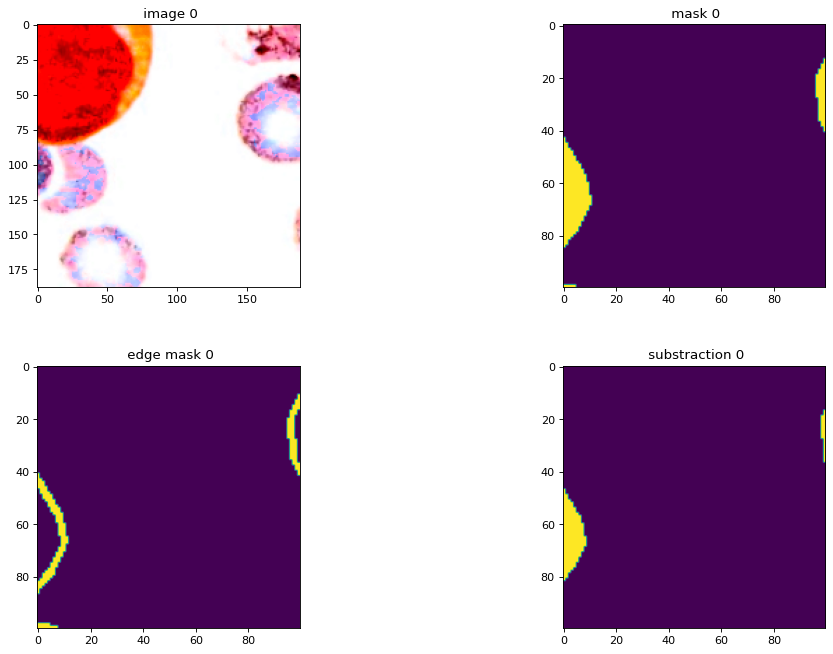

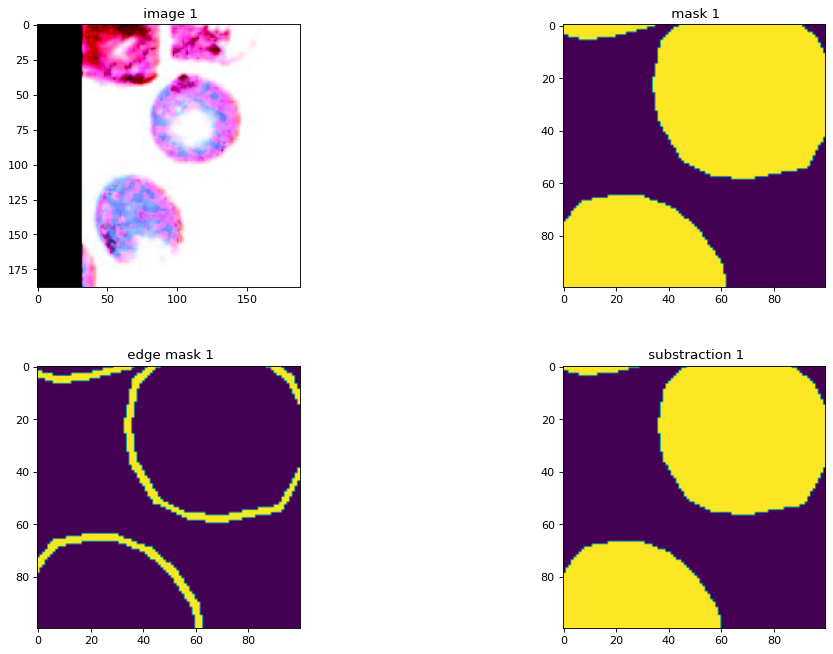

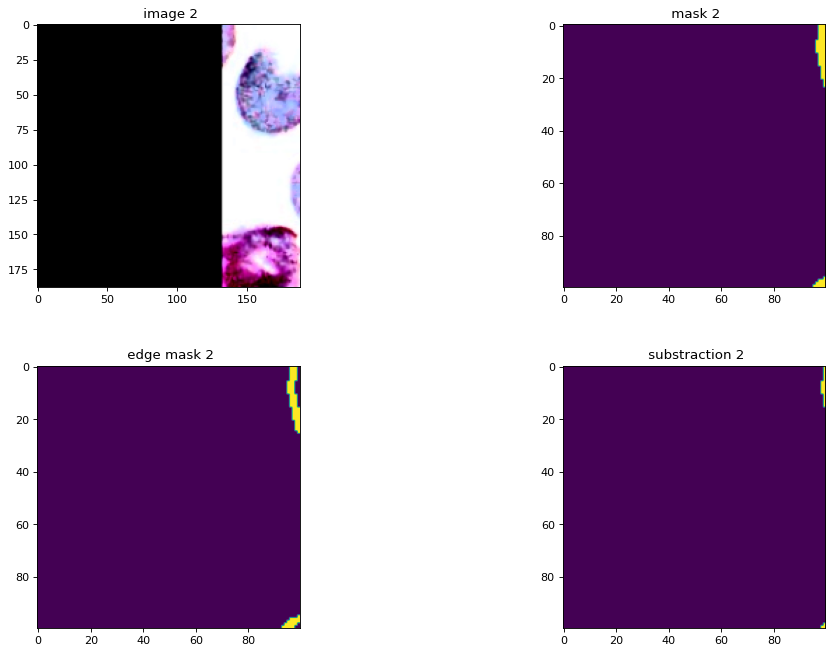

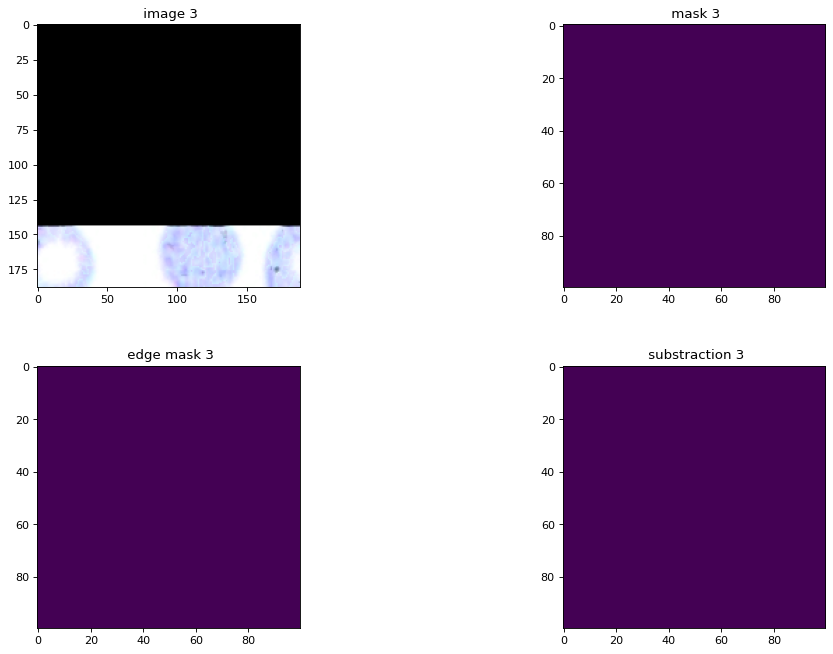

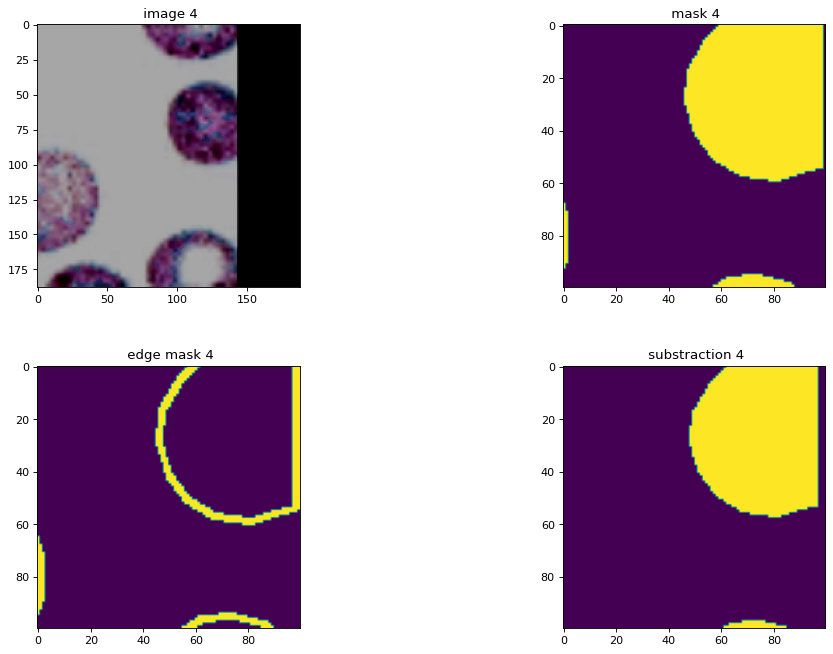

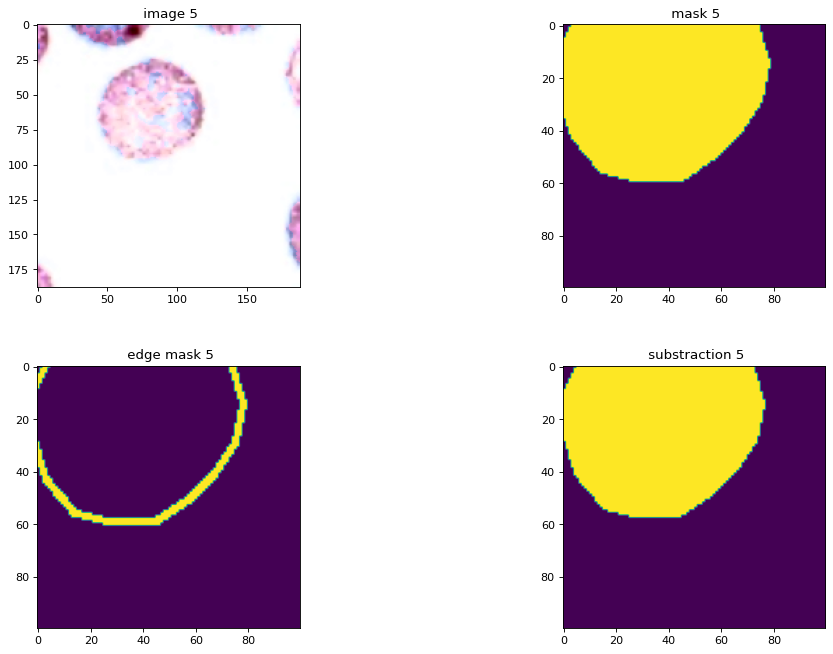

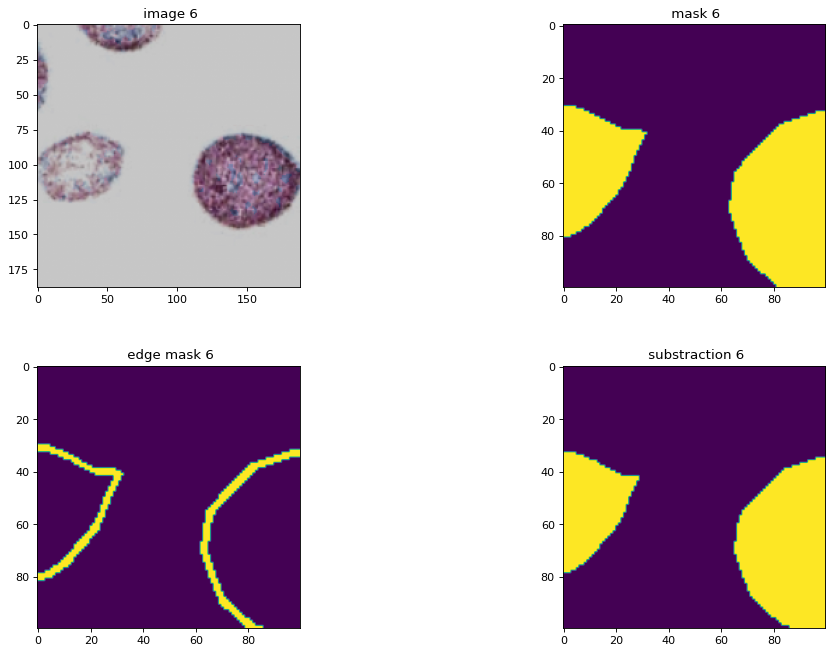

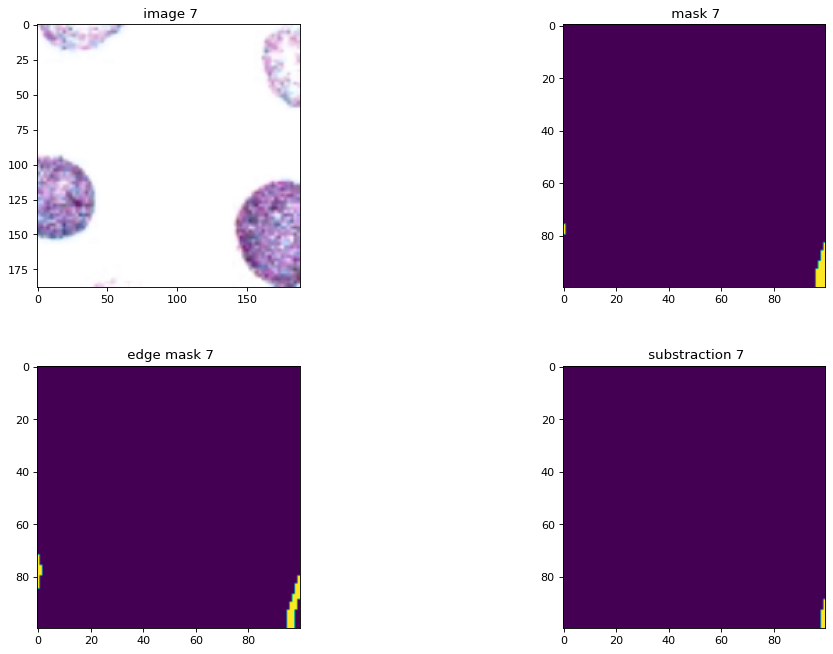

In [5]:
image, (mask, edge) = train_gen.__getitem__(16)

data.plot_ime(image, mask, edge)

- model parameters

In [9]:
_epochs = 200
_workers = 8
loss_func = "BinaryCrossentropy"
_model_name = f'RBC_{loss_func}_{database1}_{database1}_{_epochs}'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_files)//_batch_size

Train = True

- load model and compile it

In [22]:
_model_name = "RBC_BinaryCrossentropy_data2_data2_60_60_plus_60"

In [23]:
objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}


unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             loss_weights=[0.3, 0.7],
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})

#unet.summary()

- Evaluate

In [39]:
unet.evaluate(test_gen)

163/163 [==============================] - 9s 45ms/step - loss: 0.2716 - mask_loss: 0.3615 - edge_loss: 0.1816 - mask_mean_iou: 0.6365 - mask_dsc: 0.8304 - mask_tversky: 0.8232 - mask_tversky_b: 0.8349 - mask_acc: 0.8754 - edge_mean_iou: 0.0663 - edge_dsc: 0.3582 - edge_tversky: 0.3475 - edge_tversky_b: 0.3820 - edge_acc: 0.9343


[0.2715863883495331,
 0.36152714490890503,
 0.18164557218551636,
 0.6364732980728149,
 0.8303923606872559,
 0.8231993317604065,
 0.8349496126174927,
 0.875413179397583,
 0.06628389656543732,
 0.3581993877887726,
 0.34752681851387024,
 0.3820149004459381,
 0.934336245059967]

- create the model and compile it

In [37]:
unet = model.get_do_unet(compile = False)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             loss_weights=[0.5, 0.5],
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})

#unet.summary()

- load weights

In [38]:
unet.load_weights(f"models/rbc.h5")

- Train the model

In [11]:
_model_name = _model_name + "_plus_data_data_200_03_07"

In [ ]:
if Train:
    try:
        os.remove(f"models/{_model_name}_best.h5")
        os.remove(f"models/{_model_name}_all.h5")
    except:
        pass
    
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=train_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=10*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))
    # saving the model in tensorflow format
    unet.save(f'./models/{_model_name}',save_format='tf')

Epoch 1/200
Instructions for updating:
Use fn_output_signature instead


2022-06-05 22:27:13.307105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


125/125 [==============================] - ETA: 0s - loss: 0.3253 - mask_loss: 0.2209 - edge_loss: 0.3700 - mask_mean_iou: 0.6471 - mask_dsc: 0.8447 - mask_tversky: 0.8376 - mask_tversky_b: 0.8657 - mask_acc: 0.9280 - edge_mean_iou: 0.0248 - edge_dsc: 0.2288 - edge_tversky: 0.2408 - edge_tversky_b: 0.1452 - edge_acc: 0.8830
Epoch 00001: val_loss improved from inf to 0.12164, saving model to models/RBC_BinaryCrossentropy_data2_data2_60_60_plus_60_plus_data_data_200_03_07_best.h5
125/125 [==============================] - 56s 386ms/step - loss: 0.3253 - mask_loss: 0.2209 - edge_loss: 0.3700 - mask_mean_iou: 0.6471 - mask_dsc: 0.8447 - mask_tversky: 0.8376 - mask_tversky_b: 0.8657 - mask_acc: 0.9280 - edge_mean_iou: 0.0248 - edge_dsc: 0.2288 - edge_tversky: 0.2408 - edge_tversky_b: 0.1452 - edge_acc: 0.8830 - val_loss: 0.1216 - val_mask_loss: 0.1023 - val_edge_loss: 0.1300 - val_mask_mean_iou: 0.6745 - val_mask_dsc: 0.8571 - val_mask_tversky: 0.8532 - val_mask_tversky_b: 0.9365 - val_mask

- save the training log 

In [ ]:
#save the training log into a file
import json
with open(f"models/{_model_name}_log.json", "w+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

In [ ]:
#rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
#img = test_img_chips[rand_index]
#mask = np.squeeze(test_mask_chips[rand_index])
#edge = np.squeeze(test_edge_chips[rand_index])

test_img_chips, (test_mask_chips, test_edge_chips) = test_gen.__getitem__(35)


prediction = unet.predict(test_img_chips)


data.plot_ime(test_img_chips, prediction[0], prediction[1])



- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                        data.load_data_na(sorted(glob.glob(f'data/test/*.jpg'))[:20] + glob.glob(f'*.jpg'), RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')